# GIS Visualization

In [85]:
import pandas as pd
import json
import numpy as np
from datetime import datetime
from arcgis.gis import GIS
from arcgis.features import GeoAccessor, GeoSeriesAccessor
from arcgis.map.renderers import ClassBreaksRenderer


## Explore the statioin feature class

In [127]:
gis = GIS('https://osugisci.maps.arcgis.com/home', client_id='CA3qUoQUpiBSGf7x')

Please sign in to your GIS and paste the code that is obtained below.
If a web browser does not automatically open, please navigate to the URL below yourself instead.
Opening web browser to navigate to: https://osugisci.maps.arcgis.com/sharing/rest/oauth2/authorize?response_type=code&client_id=CA3qUoQUpiBSGf7x&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&state=IGnrEN6nlhdAisBnXs3ENTjZZMRjcF&allow_verification=false


In [87]:
# Search for content
search_text = 'title: Inventory_SR91 AND owner: jingx@oregonstate.edu_OSUGISci AND type: "Feature Service"'
search_result = gis.content.search(search_text)
search_result

[<Item title:"Inventory_SR91" type:Feature Layer Collection owner:jingx@oregonstate.edu_OSUGISci>]

<Item title:"Inventory_SR91" type:Feature Layer Collection owner:jingx@oregonstate.edu_OSUGISci>
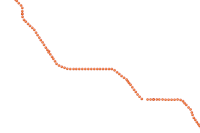

In [88]:
# Access the first item that is returned
sr_91_inventory = search_result[0]
sr_91_inventory

In [89]:
# Access the first layer of the item
sr_91_layer = sr_91_inventory.layers[0]
sr_91_layer

<FeatureLayer url:"https://services1.arcgis.com/CD5mKowwN6nIaqd8/arcgis/rest/services/Inventory_SR91/FeatureServer/0">

In [90]:
# Convert the layer to a pandas dataframe
sr_91_df = pd.DataFrame.spatial.from_layer(sr_91_layer)
sr_91_df['real_time_speed'].apply(lambda x: np.random.randint(0, 81))

0      73
1      25
2      16
3      32
4      11
       ..
106    63
107    40
108    52
109     2
110    62
Name: real_time_speed, Length: 111, dtype: int64

# Explore the zone reading

In [107]:
# Read zone readings
zone_readings_df = pd.read_csv('SR_91_Bottleneck_B_150-200/Zone_Readings_0907-0908.csv')
# Rename columns
zone_readings_df = zone_readings_df.rename(columns={'measurement_start': 'date'})
# Merge zone readings with the inventory
zone_readings_df = zone_readings_df.merge(sr_91_df, on='zone_id')
zone_readings_df = zone_readings_df[['zone_id', 'date', 'speed', 'latitude', 'longitude', 'SHAPE']]
# Convert date to datetime
zone_readings_df['date'] = pd.to_datetime(zone_readings_df['date'])
zone_readings_df['date'] = zone_readings_df['date'].dt.floor('min')
# Create a date range, 2017/09/07 - 2017/09/09, 30 minute interval.
date_range = pd.date_range(start='2017/09/07', end='2017/09/09', freq='30min', tz='US/Eastern')
# Selecte only the date range from the zone readings
zone_readings_df = zone_readings_df[zone_readings_df['date'].isin(date_range)]
# Convert date to datetime, and convert to UTC, format YYYY/MM/DD HH:MM:SS
zone_readings_df['date'] = zone_readings_df['date'].dt.tz_convert('UTC')
zone_readings_df['date'] = zone_readings_df['date'].dt.tz_localize(None)
zone_readings_df['date'] = zone_readings_df['date'].dt.strftime('%Y-%m-%dT%H:%M:%S')

zone_readings_df.head()


,zone_id,date,speed,latitude,longitude,SHAPE
0,3262,2017-09-07T04:00:00,9.909091,27.764868,-80.954325,"{""x"": -9011794.236513175, ""y"": 3219361.2370909..."
30,3262,2017-09-07T04:30:00,33.951220,27.764868,-80.954325,"{""x"": -9011794.236513175, ""y"": 3219361.2370909..."
60,3262,2017-09-07T05:00:00,49.788462,27.764868,-80.954325,"{""x"": -9011794.236513175, ""y"": 3219361.2370909..."
90,3262,2017-09-07T05:30:00,65.521739,27.764868,-80.954325,"{""x"": -9011794.236513175, ""y"": 3219361.2370909..."
120,3262,2017-09-07T06:00:00,35.928571,27.764868,-80.954325,"{""x"": -9011794.236513175, ""y"": 3219361.2370909..."


In [108]:
# Set geometry
zone_readings_df.spatial.set_geometry('SHAPE')

# Publish the zone readings to a feature layer
optional_params = {'overwrite': True, 'service':  {'featureServiceId' : '6c3702f7621b46d18aaeeea1c3fc9ac6', 'layer': 0}}
zone_readings_item = zone_readings_df.spatial.to_featurelayer(title='SR91_Zone_Readings', 
                                                              gis=gis, 
                                                              folder='ce593',
                                                              **optional_params)
                                                              

In [129]:
# Search for content
search_text = 'title: SR91_Zone_Readings AND owner: jingx@oregonstate.edu_OSUGISci AND type: "Feature Service"'
search_result = gis.content.search(search_text)
# Access the first item that is returned
zone_readings_item = search_result[0]
# Access the first layer of the item
zone_readings_layer = zone_readings_item.layers[0]

zone_readings_layer

<FeatureLayer url:"https://services1.arcgis.com/CD5mKowwN6nIaqd8/arcgis/rest/services/SR91_Zone_Readings/FeatureServer/0">

# Display web map

In [130]:
web_map =gis.map()
web_map

Map(extent={'type': 'extent', 'xmin': -17999999.999996353, 'ymin': -11999999.999994533, 'xmax': 17999999.99999…

In [139]:
# Set basemap
web_map.zoom = 10
web_map.center = [27.5,-80.7]
web_map.basemap.basemap = 'dark-gray-vector'

In [ ]:
# Get renderer
with open('item_data.json', 'r') as file:
    item_data = json.load(file)
    # drawing_info = item_data['layers'][0]['layerDefinition']['drawingInfo']
    renderer = item_data['layers'][0]['layerDefinition']['drawingInfo']['renderer']
class_breaks_renderer = ClassBreaksRenderer(**renderer)

# Plot the data using renderer
# sr_91_df.spatial.plot(map_widget=web_map, renderer=class_breaks_renderer)
web_map.content.add(zone_readings_layer, drawing_info={'renderer': class_breaks_renderer})
# #ffffff, #FC6600, #FB9900, #FFCD00, #FEFE07, #88B336, #039B01

# Enable time slider
start_time = datetime(2017, 9, 7, 4, 0, 0)
end_time = datetime(2017, 9, 9, 4, 0, 0)
web_map.time_slider.enabled = True    
time_interval = {"value":1, "units":"hours"}
web_map.time_slider.time_extent(start_time=start_time, end_time=end_time, time_interval=time_interval)


In [146]:
web_map

Map(center=[-80.69999999999864, 27.499999999999535], extent={'spatialReference': {'latestWkid': 3857, 'wkid': …